In [41]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score
import warnings
import seaborn as sns
from scipy import stats
warnings.filterwarnings('ignore')

In [6]:
# Leer el archivo como texto plano
with open('bienestar_global.csv', encoding='utf-8-sig') as f:
    lines = f.readlines()

# Quitar comillas y dividir
data = [line.strip().replace('"', '').split(';') for line in lines]

# Convertir en DataFrame
import pandas as pd
df = pd.DataFrame(data[1:], columns=data[0])  # data[0] es la cabecera
df.head()

,Item,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,0,Denmark,Western Europe,north,,928.0,53.579,224.0,81.0,278.0
1,1,,Western Europe,north,7.509,943.0,79.866,185.0,100.0,280.0
2,2,Iceland,Western Europe,north,7.501,933.0,,233.0,61.0,78.0
3,3,Norway,Western Europe,north,7.498,951.0,70.89,169.0,71.0,129.0
4,4,Finland,Western Europe,north,7.413,,43.433,263.0,133.0,97.0


In [7]:
df['HappinessScore'].describe()

,HappinessScore
count,122
unique,99
top,
freq,23


In [8]:
df.info()
#visualiza la columna NON-NULL COUNT

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Item              122 non-null    object
 1   Country           122 non-null    object
 2   Region            122 non-null    object
 3   Hemisphere        122 non-null    object
 4   HappinessScore    122 non-null    object
 5   HDI               122 non-null    object
 6   GDP_PerCapita     122 non-null    object
 7   Beer_PerCapita    122 non-null    object
 8   Spirit_PerCapita  122 non-null    object
 9   Wine_PerCapita    122 non-null    object
dtypes: object(10)
memory usage: 9.7+ KB


In [48]:
# Limpiar nombres de columnas (eliminar comillas dobles y espacios)
df.columns = df.columns.str.replace('"', '').str.strip()
# Convertir columnas numéricas
numeric_cols = ['HappinessScore', 'HDI', 'GDP_PerCapita', 'Beer_PerCapita', 'Spirit_PerCapita', 'Wine_PerCapita']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
# Confirmar que los nombres ya están limpios y correctos
df.columns.tolist()

['Item',
 'Country',
 'Region',
 'Hemisphere',
 'HappinessScore',
 'HDI',
 'GDP_PerCapita',
 'Beer_PerCapita',
 'Spirit_PerCapita',
 'Wine_PerCapita',
 'LOF_HDI',
 'ISO_Wine',
 'Hapiness_STD',
 'GDP_PerCapita_STD',
 'Spirit_norm',
 'Beer_norm',
 'Wine_norm',
 'Region_encoded']

In [49]:
#reemplazar valores de noth con north
df['Hemisphere'] = df['Hemisphere'].replace('noth', 'north')

In [50]:
df.groupby('Hemisphere')['Region'].value_counts()

Hemisphere  Region                         
            Middle East and Northern Africa     4
            Sub-Saharan Africa                  4
            Western Europe                      4
                                                2
            Latin America and Caribbean         2
            Central and Eastern Europe          1
both        Latin America and Caribbean         2
                                                1
north       Central and Eastern Europe         15
                                               13
            Western Europe                     12
            Latin America and Caribbean         5
            Southeastern Asia                   5
            Sub-Saharan Africa                  5
            Eastern Asia                        3
            Middle East and Northern Africa     3
            North America                       1
south       Sub-Saharan Africa                  8
            Latin America and Caribbean         3
            Australia and New Zealand           2
Name: count, dtype: int64

Valores Faltantes y Duplicados

In [14]:
df.isnull().sum()
#para contar los valores faltantes por columna.

,0
Item,0
Country,0
Region,0
Hemisphere,0
HappinessScore,0
HDI,0
GDP_PerCapita,0
Beer_PerCapita,0
Spirit_PerCapita,0
Wine_PerCapita,0


<Axes: >

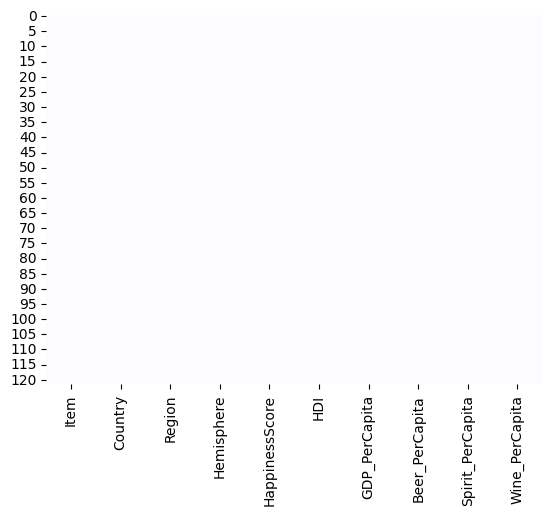

In [15]:
sns.heatmap(df.isnull(), cbar=False, cmap='Purples')
#para una visualización de los faltantes.

Corregir los datos: extraer solo el primer valor de cada celda

In [24]:
# Ver un ejemplo del contenido
print(df['HappinessScore'].head(3))

0      NaN
1    7.509
2    7.501
Name: HappinessScore, dtype: float64


In [21]:
# Si la columna contiene strings con varios valores separados por coma, tomar el primero
df['HappinessScore'] = df['HappinessScore'].astype(str).apply(lambda x: x.split(',')[0])
# Convertir a número
df['HappinessScore'] = pd.to_numeric(df['HappinessScore'], errors='coerce')

In [22]:
#Moda: Imputar con la moda de la columna
moda_por_grupo = df.groupby(['Hemisphere'])[['Region']].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
moda_por_grupo

,Region
0,Central and Eastern Europe
1,Central and Eastern Europe
2,Central and Eastern Europe
3,Central and Eastern Europe
4,Central and Eastern Europe
...,...
117,Sub-Saharan Africa
118,Central and Eastern Europe
119,Central and Eastern Europe
120,Central and Eastern Europe


In [25]:
# Lista de columnas a convertir
cols = ['Wine_PerCapita', 'Spirit_PerCapita', 'Beer_PerCapita', 'GDP_PerCapita', 'HDI']
# Convertir strings a valores numéricos (float), forzando errores como NaN
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [26]:
# Rellenar según cada tipo de estadístico
df['Wine_PerCapita'] = df['Wine_PerCapita'].fillna(df['Wine_PerCapita'].mode()[0])
df['Spirit_PerCapita'] = df['Spirit_PerCapita'].fillna(df['Spirit_PerCapita'].median())
df['Beer_PerCapita'] = df['Beer_PerCapita'].fillna(df['Beer_PerCapita'].mode()[0])
df['GDP_PerCapita'] = df['GDP_PerCapita'].fillna(df['GDP_PerCapita'].mode()[0])
df['HDI'] = df['HDI'].fillna(df['HDI'].mean())

In [28]:
print(df[cols].isnull().sum())
print(df[cols].describe())

Wine_PerCapita      0
Spirit_PerCapita    0
Beer_PerCapita      0
GDP_PerCapita       0
HDI                 0
dtype: int64
       Wine_PerCapita  Spirit_PerCapita  Beer_PerCapita  GDP_PerCapita  \
count      122.000000        122.000000      122.000000     122.000000   
mean        53.393443         88.090164      115.713115      82.009656   
std         83.104590         71.065562      102.640146     206.018729   
min          1.000000          1.000000        1.000000       1.029000   
25%          1.000000         35.000000       25.000000       1.970750   
50%          8.000000         76.000000       77.000000       7.054000   
75%         77.000000        122.000000      196.750000      37.103250   
max        370.000000        373.000000      361.000000     953.000000   

              HDI  
count  122.000000  
mean   748.653061  
std    133.764200  
min    351.000000  
25%    711.500000  
50%    748.653061  
75%    844.750000  
max    951.000000  


In [27]:
df.isnull().sum()

,0
Item,0
Country,0
Region,0
Hemisphere,0
HappinessScore,23
HDI,0
GDP_PerCapita,0
Beer_PerCapita,0
Spirit_PerCapita,0
Wine_PerCapita,0


In [29]:
#Para duplicados basados en un subconjunto de columnas (ej. Country), usar
df.duplicated(subset=['Country']).sum()

np.int64(27)

In [30]:
# prompt: borrar filas con países duplicados

df.drop_duplicates(subset=['Country'], inplace=True)
df.duplicated(subset=['Country']).sum()

np.int64(0)

Detección de Outliers

In [31]:
from scipy import stats
thresholdZ = 1.6
z_scores = stats.zscore(df['HappinessScore'])
outliersZ = df[abs(z_scores) > thresholdZ]
outliersZ.count().sort_values()

,0
Item,0
Country,0
Region,0
Hemisphere,0
HappinessScore,0
HDI,0
GDP_PerCapita,0
Beer_PerCapita,0
Spirit_PerCapita,0
Wine_PerCapita,0


In [32]:
# prompt: calcula el LOF de la columna HDI
from sklearn.neighbors import LocalOutlierFactor

# Calculate the LOF for the 'HDI' column
# Reshape the 'HDI' column to be 2D as required by LOF
X = df[['HDI']]

# Calculate LOF scores
lof = LocalOutlierFactor(n_neighbors=20)
outliersL_hdi = lof.fit_predict(X)

# Add the LOF scores for 'HDI' to the DataFrame
df["LOF_HDI"] = outliersL_hdi

# Display the rows with potential outliers based on LOF for 'HDI'
print("Potential outliers based on LOF for 'HDI':")
display(df[df["LOF_HDI"] == -1])

Potential outliers based on LOF for 'HDI':


,Item,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita,LOF_HDI
15,15,Brazil,,both,6.952,758.0,8.639,245.0,145.0,16.0,-1
27,27,Uruguay,Latin America and Caribbean,,6.545,802.0,15.298,115.0,35.0,220.0,-1
31,31,Thailand,Southeastern Asia,north,6.474,748.0,5.979,99.0,258.0,1.0,-1
35,35,Suriname,Latin America and Caribbean,north,6.269,719.0,1.029,128.0,178.0,7.0,-1
37,37,Trinidad and Tobago,Latin America and Caribbean,north,6.168,785.0,16.352,197.0,156.0,7.0,-1
45,45,Belize,,,5.956,709.0,4.960,263.0,114.0,8.0,-1
47,47,Kazakhstan,Central and Eastern Europe,,5.919,797.0,7.715,124.0,246.0,12.0,-1
48,48,Moldova,,north,5.897,697.0,1.913,109.0,226.0,18.0,-1
57,57,Turkmenistan,Central and Eastern Europe,north,5.658,705.0,6.389,19.0,71.0,32.0,-1
58,58,Mauritius,Sub-Saharan Africa,north,5.648,788.0,1.029,25.0,31.0,18.0,-1


In [33]:
from sklearn.ensemble import IsolationForest
X = df[['Wine_PerCapita']]

iso = IsolationForest(contamination=0.1)
outliers_iso = iso.fit_predict(X)
df["ISO_Wine"] = outliers_iso
df

,Item,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita,LOF_HDI,ISO_Wine
0,0,Denmark,Western Europe,north,NaN,928.000000,53.579,224.0,81.0,278.0,1,-1
1,1,,Western Europe,north,7.509,943.000000,79.866,185.0,100.0,280.0,1,-1
2,2,Iceland,Western Europe,north,7.501,933.000000,1.029,233.0,61.0,78.0,1,1
3,3,Norway,Western Europe,north,7.498,951.000000,70.890,169.0,71.0,129.0,1,1
4,4,Finland,Western Europe,north,7.413,748.653061,43.433,263.0,133.0,97.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
116,116,Madagascar,Sub-Saharan Africa,south,3.695,748.653061,402.000,25.0,15.0,4.0,1,1
118,118,Liberia,,north,3.622,432.000000,455.000,19.0,152.0,2.0,-1,1
119,119,Benin,,north,3.484,512.000000,789.000,34.0,4.0,1.0,-1,1
120,120,Togo,,north,NaN,500.000000,577.000,36.0,2.0,19.0,-1,1


Norm, Estan, Cod

In [34]:
# prompt: usar one-hot para la columna hemisfere

from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column
encoder_df = pd.DataFrame(encoder.fit_transform(df[['Hemisphere']]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df = df.join(encoder_df)

#view final df
print(final_df)

    Item     Country                           Region Hemisphere  \
0      0     Denmark                   Western Europe      north   
1      1                               Western Europe      north   
2      2     Iceland                   Western Europe      north   
3      3      Norway                   Western Europe      north   
4      4     Finland                   Western Europe      north   
..   ...         ...                              ...        ...   
116  116  Madagascar               Sub-Saharan Africa      south   
118  118     Liberia                                       north   
119  119       Benin                                       north   
120  120        Togo                                       north   
121  121       Syria  Middle East and Northern Africa      north   

     HappinessScore         HDI  GDP_PerCapita  Beer_PerCapita  \
0               NaN  928.000000         53.579           224.0   
1             7.509  943.000000         79.866     

In [35]:
# Estandariza HappinessScore, GDP_PerCapita
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Select the columns to standardize
df['Hapiness' + '_STD'] = scaler.fit_transform(df[['HappinessScore']])
df['GDP_PerCapita' + '_STD'] = scaler.fit_transform(df[['GDP_PerCapita']])
# Display the updated DataFrame
print(df.head())

  Item  Country          Region Hemisphere  HappinessScore         HDI  \
0    0  Denmark  Western Europe      north             NaN  928.000000   
1    1           Western Europe      north           7.509  943.000000   
2    2  Iceland  Western Europe      north           7.501  933.000000   
3    3   Norway  Western Europe      north           7.498  951.000000   
4    4  Finland  Western Europe      north           7.413  748.653061   

   GDP_PerCapita  Beer_PerCapita  Spirit_PerCapita  Wine_PerCapita  LOF_HDI  \
0         53.579           224.0              81.0           278.0        1   
1         79.866           185.0             100.0           280.0        1   
2          1.029           233.0              61.0            78.0        1   
3         70.890           169.0              71.0           129.0        1   
4         43.433           263.0             133.0            97.0        1   

   ISO_Wine  Hapiness_STD  GDP_PerCapita_STD  
0        -1           NaN        

In [36]:
#Transformar Beer_PerCapita, Spirit_PerCapita, Wine_PerCapita a un rango [0,1]
df['Spirit_norm'] = (df['Spirit_PerCapita'] - df['Spirit_PerCapita'].min()) / (df['Spirit_PerCapita'].max() - df['Spirit_PerCapita'].min())
df['Beer_norm'] = (df['Beer_PerCapita'] - df['Beer_PerCapita'].min()) / (df['Beer_PerCapita'].max() - df['Beer_PerCapita'].min())
df['Wine_norm'] = (df['Wine_PerCapita'] - df['Wine_PerCapita'].min()) / (df['Wine_PerCapita'].max() - df['Wine_PerCapita'].min())

In [37]:
print(df.head())

  Item  Country          Region Hemisphere  HappinessScore         HDI  \
0    0  Denmark  Western Europe      north             NaN  928.000000   
1    1           Western Europe      north           7.509  943.000000   
2    2  Iceland  Western Europe      north           7.501  933.000000   
3    3   Norway  Western Europe      north           7.498  951.000000   
4    4  Finland  Western Europe      north           7.413  748.653061   

   GDP_PerCapita  Beer_PerCapita  Spirit_PerCapita  Wine_PerCapita  LOF_HDI  \
0         53.579           224.0              81.0           278.0        1   
1         79.866           185.0             100.0           280.0        1   
2          1.029           233.0              61.0            78.0        1   
3         70.890           169.0              71.0           129.0        1   
4         43.433           263.0             133.0            97.0        1   

   ISO_Wine  Hapiness_STD  GDP_PerCapita_STD  Spirit_norm  Beer_norm  \
0       

In [38]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Region_encoded'] = label_encoder.fit_transform(df['Region'])
print(df)

    Item     Country                           Region Hemisphere  \
0      0     Denmark                   Western Europe      north   
1      1                               Western Europe      north   
2      2     Iceland                   Western Europe      north   
3      3      Norway                   Western Europe      north   
4      4     Finland                   Western Europe      north   
..   ...         ...                              ...        ...   
116  116  Madagascar               Sub-Saharan Africa      south   
118  118     Liberia                                       north   
119  119       Benin                                       north   
120  120        Togo                                       north   
121  121       Syria  Middle East and Northern Africa      north   

     HappinessScore         HDI  GDP_PerCapita  Beer_PerCapita  \
0               NaN  928.000000         53.579           224.0   
1             7.509  943.000000         79.866     

<Axes: >

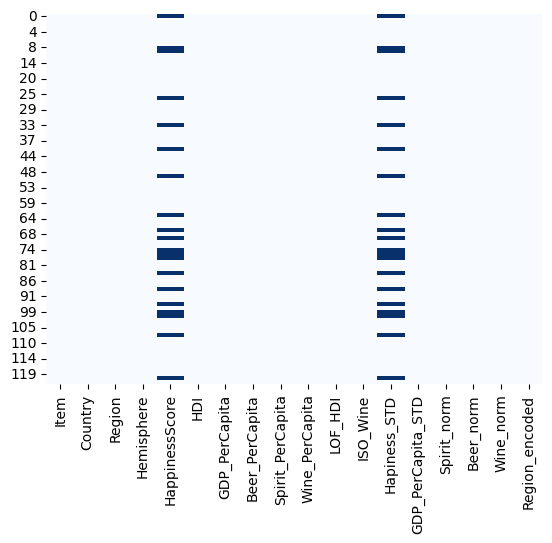

In [39]:
sns.heatmap(df.isnull(), cbar=False, cmap='Blues')
#para una visualización de los faltantes.

In [42]:
# Asegurarse de que ya está cargado y convertido correctamente
numeric_cols = ['Wine_PerCapita', 'Spirit_PerCapita', 'Beer_PerCapita', 'GDP_PerCapita', 'HDI']
df_numeric = df[numeric_cols]

Z-SCORE

In [43]:
# Detección por Z-score (|z| > 3)
z_scores = np.abs(stats.zscore(df_numeric))
outliers_zscore = (z_scores > 3).sum()
print("Outliers detectados con Z-score:")
print(pd.Series(outliers_zscore, index=numeric_cols))

Outliers detectados con Z-score:
Wine_PerCapita      7
Spirit_PerCapita    7
Beer_PerCapita      7
GDP_PerCapita       7
HDI                 7
dtype: int64


IQR (Rango Intercuartílico)

In [44]:
outliers_iqr = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    count = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    outliers_iqr[col] = count
print("Outliers detectados con IQR:")
print(pd.Series(outliers_iqr))

Outliers detectados con IQR:
Wine_PerCapita       5
Spirit_PerCapita     3
Beer_PerCapita       0
GDP_PerCapita       10
HDI                 13
dtype: int64


Percentiles (1% y 99%)

In [45]:
outliers_percentile = {}
for col in numeric_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    count = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    outliers_percentile[col] = count
print("Outliers detectados con Percentiles (1%-99%):")
print(pd.Series(outliers_percentile))

Outliers detectados con Percentiles (1%-99%):
Wine_PerCapita      1
Spirit_PerCapita    1
Beer_PerCapita      1
GDP_PerCapita       1
HDI                 2
dtype: int64


Boxplot (mismos límites que IQR pero visuales)

In [46]:
# Reutiliza los límites IQR como base para "Boxplot"
outliers_boxplot = outliers_iqr  # Son iguales
print("Outliers estimados por Boxplot:")
print(pd.Series(outliers_boxplot))

Outliers estimados por Boxplot:
Wine_PerCapita       5
Spirit_PerCapita     3
Beer_PerCapita       0
GDP_PerCapita       10
HDI                 13
dtype: int64


In [52]:
print("Resumen de outliers detectados por técnica:")
print(summary_df)

Resumen de outliers detectados por técnica:
                  Z-Score  IQR  Percentil_1-99  Boxplot
HappinessScore          0    0               2        0
HDI                     0   13               2       13
GDP_PerCapita           4   10               1       10
Beer_PerCapita          0    0               1        0
Spirit_PerCapita        1    3               1        3
Wine_PerCapita          2    5               1        5


Resumen de outliers detectados por técnica:
                  Z-Score  IQR  Percentil_1-99  Boxplot
HappinessScore          0    0               2        0
HDI                     0   13               2       13
GDP_PerCapita           4   10               1       10
Beer_PerCapita          0    0               1        0
Spirit_PerCapita        1    3               1        3
Wine_PerCapita          2    5               1        5


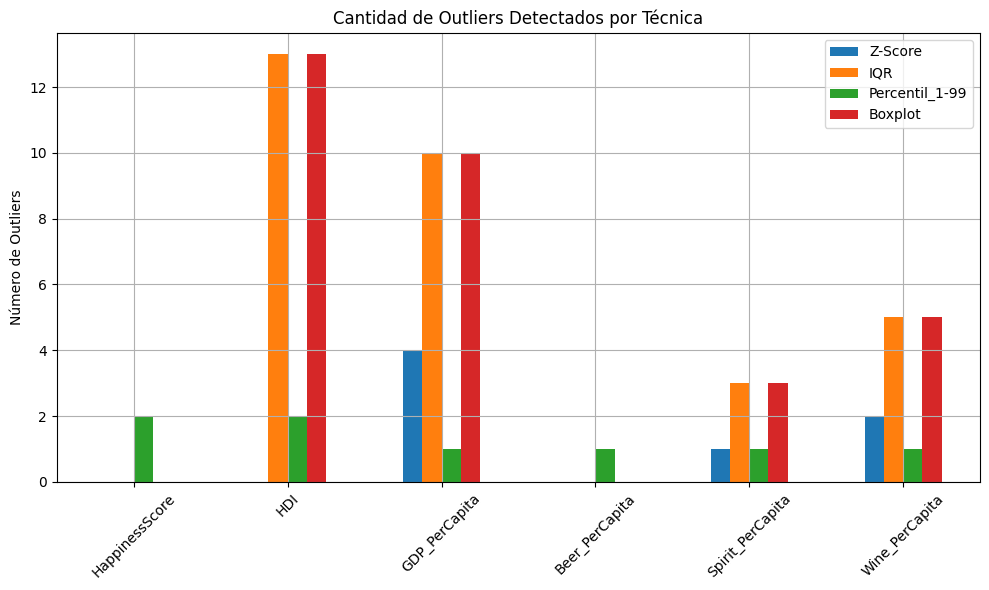

In [53]:
# Mostrar resumen de outliers en Google Colab
print("Resumen de outliers detectados por técnica:")
print(summary_df)
# (Gráfica sigue funcionando normalmente)
summary_df.plot(kind='bar', figsize=(10, 6))
plt.title('Cantidad de Outliers Detectados por Técnica')
plt.ylabel('Número de Outliers')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()